# Model Interpretability Analysis

This notebook analyzes the DuaLK model's interpretability through:
1. Disease-level embedding evolution (HAKE initialization vs. trained GNN embeddings)
2. Attention score analysis for case study patients

## 1. Setup and Data Loading

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

from models.model import DuaLK

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

In [2]:
data_path = 'data/mimic3'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

initial_embeddings = torch.load('./saved/train/initial_embeddings.pth', map_location='cpu')
checkpoint = torch.load('./saved/train/checkpoint.pth', map_location='cpu')

with open(f'{data_path}/encoded/code_maps.pkl', 'rb') as f:
    maps = pickle.load(f)
    code_map_pretrain = maps['code_map_pretrain']

with open(f'{data_path}/standard/codes_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
    test_codes_x, test_codes_y, test_labs_x, _ = dataset['test_codes_data']

with open(f'{data_path}/graph/disease2disease.pkl', 'rb') as f:
    graph_data = pickle.load(f)
    edge_index = graph_data['edge_index']
    edge_weight = graph_data['edge_weight']

print(f'Initial embeddings shape: {initial_embeddings.shape}')
print(f'Test data shape: {test_codes_x.shape}')
print(f'Number of codes in code_map_pretrain: {len(code_map_pretrain)}')

Initial embeddings shape: torch.Size([6982, 2000])
Test data shape: (1000, 42, 39)
Number of codes in code_map_pretrain: 6981


## 2. ICD-9 Code Mapping

In [3]:
icd9_dict = {
    "Heart Failure": [
        "428.0", "428.1",
        "428.20", "428.21", "428.22", "428.23",
        "428.30", "428.31", "428.32", "428.33",
        "428.40", "428.41", "428.42", "428.43",
        "428.9"
    ],
    "Hypertension": [
        "401.0", "401.1", "401.9"
    ],
    "Acute Rheumatic Fever": [
        "390",
        "391.0", "391.1", "391.2", "391.8", "391.9",
        "392.0", "392.9"
    ]
}

disease_colors = {
    "Heart Failure": "#3498db",
    "Hypertension": "#e74c3c",
    "Acute Rheumatic Fever": "#2ecc71"
}

disease_indices = {}
for disease, codes in icd9_dict.items():
    indices = []
    for code in codes:
        if code in code_map_pretrain:
            indices.append(code_map_pretrain[code])
    disease_indices[disease] = indices
    print(f'{disease}: {len(indices)} codes found')

all_disease_indices = []
all_disease_labels = []
for disease, indices in disease_indices.items():
    all_disease_indices.extend(indices)
    all_disease_labels.extend([disease] * len(indices))

print(f'\nTotal disease codes to visualize: {len(all_disease_indices)}')

Heart Failure: 15 codes found
Hypertension: 3 codes found
Acute Rheumatic Fever: 4 codes found

Total disease codes to visualize: 22


## 3. Embedding Evolution Visualization

In [4]:
model_config = {
    'init_dim': 2000,
    'GNN': {
        'type': 'gat',
        'dims': (256, 256),
        'dropout': 0.,
    },
    'Attention': {
        'dropout': 0.2,
    },
    'Decoder': {
        'dims': (256, 128),
        'dropout': 0.4,
    },
    'Classifier': {
        'dims': [256],
        'dropout': 0.4,
    }
}

num_classes = [159, 115, 16, test_codes_y.shape[1]]

data = Data(x=initial_embeddings.float(), 
            edge_index=torch.tensor(edge_index), 
            edge_weight=torch.tensor(edge_weight).float())

model = DuaLK(model_config=model_config, emb_init=data.x, num_classes=num_classes,
              use_lab=True, code_fuse='simple', visit_fuse='simple', 
              train_type='finetune', gnn_type='gat')
model.load_state_dict(checkpoint)
model.eval()

print('Model loaded successfully')

Model loaded successfully


In [5]:
initial_emb_all = initial_embeddings.numpy()

with torch.no_grad():
    trained_emb_full = model.gnn_layer(data.edge_index, data.edge_weight)
trained_emb_all = trained_emb_full.cpu().numpy()

print(f'All embeddings shape: Initial={initial_emb_all.shape}, Trained={trained_emb_all.shape}')
print(f'Will visualize {len(all_disease_indices)} disease codes from the full embedding space')

All embeddings shape: Initial=(6982, 2000), Trained=(6982, 256)
Will visualize 22 disease codes from the full embedding space


In [6]:
tsne_init = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
coords_init_all = tsne_init.fit_transform(initial_emb_all)

tsne_trained = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
coords_trained_all = tsne_trained.fit_transform(trained_emb_all)

coords_init = coords_init_all[all_disease_indices]
coords_trained = coords_trained_all[all_disease_indices]

print(f't-SNE completed on {len(initial_emb_all)} diseases')
print(f'Extracted coordinates for {len(all_disease_indices)} target diseases')

t-SNE completed on 6982 diseases
Extracted coordinates for 22 target diseases


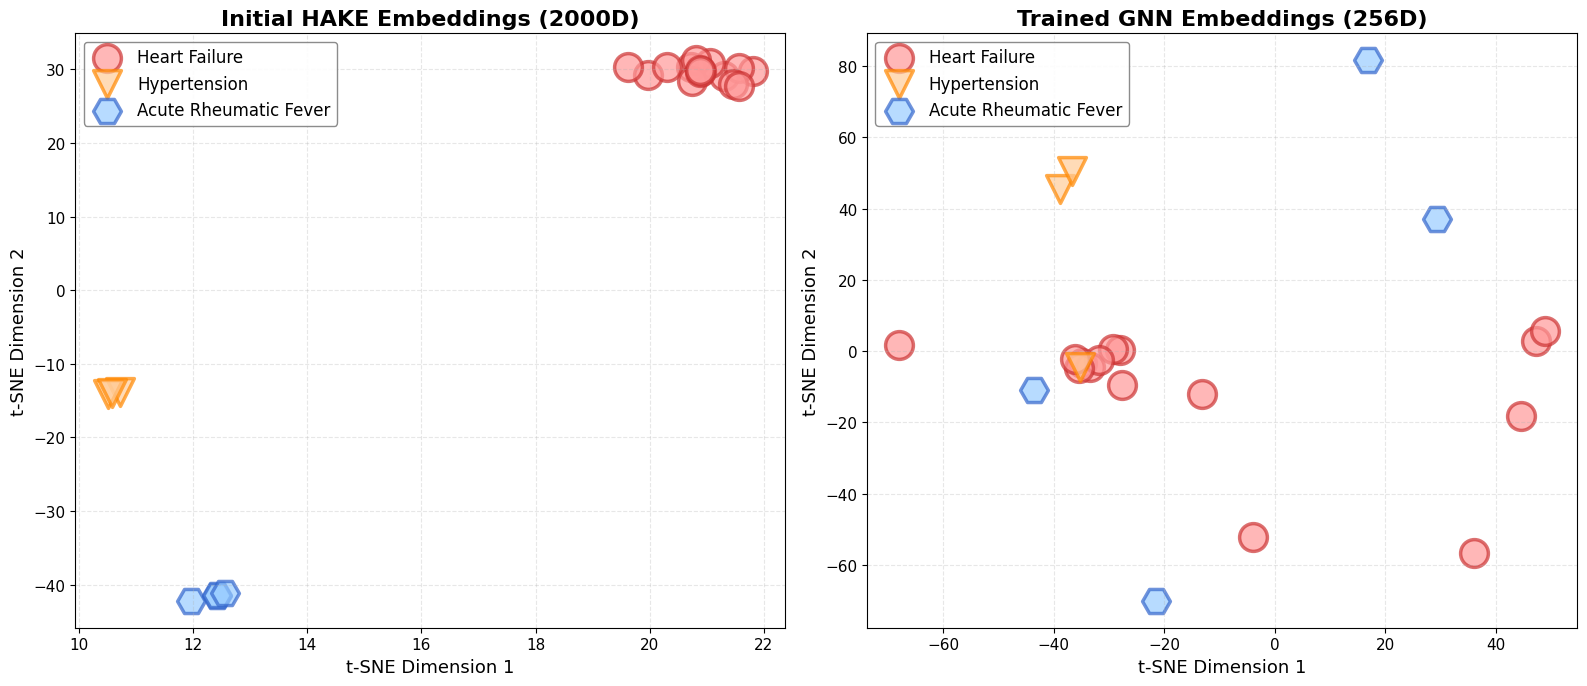

In [7]:
disease_markers = {
    "Heart Failure": "o", 
    "Hypertension": "v", 
    "Acute Rheumatic Fever": "H" 
}

disease_colors_main = {
    "Heart Failure": "#ff9999", 
    "Hypertension": "#ffcc99",
    "Acute Rheumatic Fever": "#99ccff"
}

disease_colors_edge = {
    "Heart Failure": "#cc3333",
    "Hypertension": "#ff8800", 
    "Acute Rheumatic Fever": "#3366cc" 
}

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for disease in disease_indices.keys():
    mask = [label == disease for label in all_disease_labels]
    axes[0].scatter(coords_init[mask, 0], coords_init[mask, 1], 
                   c=disease_colors_main[disease], 
                   marker=disease_markers[disease],
                   label=disease,
                   s=400, alpha=0.7, 
                   edgecolors=disease_colors_edge[disease], 
                   linewidth=2.5)

axes[0].set_title('Initial HAKE Embeddings (2000D)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=13)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=13)
axes[0].legend(loc='best', frameon=True, fontsize=12, framealpha=0.9, edgecolor='gray')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].tick_params(labelsize=11)

for disease in disease_indices.keys():
    mask = [label == disease for label in all_disease_labels]
    axes[1].scatter(coords_trained[mask, 0], coords_trained[mask, 1],
                   c=disease_colors_main[disease],
                   marker=disease_markers[disease],
                   label=disease,
                   s=400, alpha=0.7,
                   edgecolors=disease_colors_edge[disease],
                   linewidth=2.5)

axes[1].set_title('Trained GNN Embeddings (256D)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=13)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=13)
axes[1].legend(loc='best', frameon=True, fontsize=12, framealpha=0.9, edgecolor='gray')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].tick_params(labelsize=11)

plt.tight_layout()
plt.show()

## 5. Patient Selection for Case Studies

In [8]:
visit_counts = (test_codes_x != 0).any(axis=-1).sum(axis=1)
valid_visit_mask = (visit_counts >= 2) & (visit_counts <= 4)
valid_patient_indices = np.where(valid_visit_mask)[0]

print(f'Patients with 3-5 visits (2-4 in X, 1 in y): {len(valid_patient_indices)}')

np.random.seed(42)
selected_patient_indices = np.random.choice(valid_patient_indices, size=5, replace=False)

print(f'Selected patient indices: {selected_patient_indices}')

Patients with 3-5 visits (2-4 in X, 1 in y): 253
Selected patient indices: [843  24 296 814 450]


## 4. ICD-9 Code to Disease Name Mapping

In [9]:
from preprocess.auxiliary import load_icd2name

icd2name, unmatched = load_icd2name('resources', code_map_pretrain)
print(f'Loaded {len(icd2name)} ICD-9 code descriptions')
print(f'Unmatched codes: {len(unmatched)}')

reverse_code_map = {v: k for k, v in code_map_pretrain.items()}

def get_disease_name(code_idx):
    icd_code = reverse_code_map.get(code_idx, None)
    if icd_code and icd_code in icd2name and icd2name[icd_code] is not None:
        return f"{icd2name[icd_code]} ({icd_code})"
    elif icd_code:
        return f"Code {icd_code}"
    return f"Unknown code {code_idx}"

There is 0 unmatched ICD9CM codes
Loaded 6981 ICD-9 code descriptions
Unmatched codes: 0


In [10]:
def extract_attention_scores(model, data, patient_codes_x):
    model.eval()
    codes_x = torch.tensor(patient_codes_x).unsqueeze(0).to(device)
    
    embeddings = model.gnn_layer(data.edge_index.to(device), data.edge_weight.to(device))
    
    visit_attention_scores = []
    visit_codes_list = []
    
    with torch.no_grad():
        for visit in range(codes_x.shape[1]):
            visit_codes = codes_x[0, visit, :]
            visit_codes = visit_codes[visit_codes > 0]
            if len(visit_codes) == 0:
                continue
            
            code_embeddings = embeddings[visit_codes]
            _, visit_attn = model.visit_attention(code_embeddings, return_attention=True)
            
            visit_attention_scores.append(visit_attn.cpu().numpy())
            visit_codes_list.append(visit_codes.cpu().numpy())
        
        visit_embeddings = []
        for visit in range(codes_x.shape[1]):
            visit_codes = codes_x[0, visit, :]
            visit_codes = visit_codes[visit_codes > 0]
            if len(visit_codes) == 0:
                continue
            code_embeddings = embeddings[visit_codes]
            visit_embedding = model.visit_attention(code_embeddings)
            visit_embeddings.append(visit_embedding)
        
        if len(visit_embeddings) > 0:
            visit_embeddings_tensor = torch.stack(visit_embeddings)
            _, patient_attn = model.patient_attention(visit_embeddings_tensor, return_attention=True)
            patient_attention_scores = patient_attn.cpu().numpy()
        else:
            patient_attention_scores = None
    
    return visit_attention_scores, visit_codes_list, patient_attention_scores

## 7. Case Study Analysis

In [11]:
data = data.to(device)
model = model.to(device)

for patient_idx in selected_patient_indices:
    patient_codes = test_codes_x[patient_idx]
    patient_labels = test_codes_y[patient_idx]
    
    visit_attn_scores, visit_codes, patient_attn_scores = extract_attention_scores(
        model, data, patient_codes
    )
    
    print(f"\n{'='*80}")
    print(f"Patient {patient_idx}")
    print(f"{'='*80}\n")
    
    for visit_idx, (codes, attn) in enumerate(zip(visit_codes, visit_attn_scores)):
        print(f"  Visit {visit_idx + 1}:")
        attn_mean = attn.mean(axis=-1)[:len(codes)]
        
        for code, att in zip(codes, attn_mean):
            disease_name = get_disease_name(int(code))
            print(f"    - {disease_name}: attention = {att:.4f}")
        
        if patient_attn_scores is not None:
            patient_att = patient_attn_scores.mean(axis=-1)[visit_idx]
            print(f"    Visit {visit_idx + 1} overall attention: {patient_att:.4f}\n")
    
    predicted_indices = np.where(patient_labels > 0)[0]
    print(f"  Predicted diseases in next visit:")
    for idx in predicted_indices[:10]:
        disease_name = get_disease_name(int(idx))
        print(f"    - {disease_name}")
    print(f"\n{'='*80}\n")


Patient 843

  Visit 1:
    - Edema of larynx (478.6): attention = 0.1276
    - Other convulsions (780.39): attention = 0.1078
    - Abscess of lung (513.0): attention = 0.0643
    - Other pulmonary embolism and infarction (415.19): attention = 0.0458
    - Acute respiratory failure (518.81): attention = 0.0756
    - Systemic lupus erythematosus (710.0): attention = 0.1506
    - Nephritis and nephropathy, not specified as acute or chronic, in diseases classified elsewhere (583.81): attention = 0.1763
    - Raynaud's syndrome (443.0): attention = 0.1401
    - Hypopotassemia (276.8): attention = 0.1118
    Visit 1 overall attention: 0.4728

  Visit 2:
    - End stage renal disease (585.6): attention = 0.2047
    - Pneumonia, organism unspecified (486): attention = 0.0592
    - Primary hypercoagulable state (289.81): attention = 0.1267
    - Systemic lupus erythematosus (710.0): attention = 0.1678
    - Awaiting organ transplant status (V49.83): attention = 0.0261
    - Chronic glomerulo

In [12]:
import pandas as pd

with open(f'{data_path}/encoded/code_maps.pkl', 'rb') as f:
    maps = pickle.load(f)
    lab_map = maps['lab_map']

lab_items_df = pd.read_csv(f'{data_path}/raw/D_LABITEMS.csv.gz', 
                          usecols=['ITEMID', 'LABEL', 'CATEGORY'])
lab_items_df['CATEGORY'] = lab_items_df['CATEGORY'].str.lower()

def create_lab_index_to_name(lab_map_category, lab_items_df):
    reverse_map = {v: k for k, v in lab_map_category.items()}
    index_to_name = {}
    for idx, itemid in reverse_map.items():
        lab_info = lab_items_df[lab_items_df['ITEMID'] == itemid]
        if not lab_info.empty:
            label = lab_info.iloc[0]['LABEL']
            category = lab_info.iloc[0]['CATEGORY']
            index_to_name[idx] = f"{label} [{category}]"
        else:
            index_to_name[idx] = f"Lab {itemid}"
    return index_to_name

hema_idx_to_name = create_lab_index_to_name(lab_map['hematology'], lab_items_df)
chem_idx_to_name = create_lab_index_to_name(lab_map['chemistry'], lab_items_df)
blood_idx_to_name = create_lab_index_to_name(lab_map['blood gas'], lab_items_df)

print(f'Hematology lab tests: {len(hema_idx_to_name)}')
print(f'Chemistry lab tests: {len(chem_idx_to_name)}')
print(f'Blood gas lab tests: {len(blood_idx_to_name)}')
print(f'Total unique lab tests: {len(lab_map["all"])}')

Hematology lab tests: 159
Chemistry lab tests: 115
Blood gas lab tests: 16
Total unique lab tests: 290


In [13]:
def compute_integrated_gradients(model, data, patient_codes, patient_labs, diagnosis_idx, num_steps=50, baseline_type='zero'):
    model.eval()
    
    codes_x = torch.tensor(patient_codes).unsqueeze(0).to(device)
    labs_x = torch.tensor(patient_labs).unsqueeze(0).float().to(device)
    
    embeddings = model.gnn_layer(data.edge_index.to(device), data.edge_weight.to(device))
    
    visit_embeddings = []
    for visit in range(codes_x.shape[1]):
        visit_codes = codes_x[0, visit, :]
        visit_codes = visit_codes[visit_codes > 0]
        if len(visit_codes) == 0:
            continue
        code_embeddings = embeddings[visit_codes]
        visit_embedding = model.visit_attention(code_embeddings)
        visit_embeddings.append(visit_embedding)
    
    if len(visit_embeddings) == 0:
        return None, None, None
    
    visit_embeddings_tensor = torch.stack(visit_embeddings)
    patient_emb = model.patient_attention(visit_embeddings_tensor)

    patient_emb = patient_emb.unsqueeze(0).detach()

    with torch.no_grad():
        lab_emb1 = model.decoder1.extract_embeddings(patient_emb)
        lab_emb2 = model.decoder2.extract_embeddings(patient_emb)
        lab_emb3 = model.decoder3.extract_embeddings(patient_emb)
    
    actual_lab_embs = torch.cat([lab_emb1, lab_emb2, lab_emb3], dim=-1)
    
    if baseline_type == 'zero':
        baseline_lab_embs = torch.zeros_like(actual_lab_embs)
    else:
        baseline_lab_embs = torch.zeros_like(actual_lab_embs)
    
    integrated_grads = torch.zeros_like(actual_lab_embs)

    with torch.no_grad():
        if model.use_lab:
            lab_layer_output = F.relu(model.lab_layer(labs_x))
    
    for alpha in torch.linspace(0, 1, num_steps):

        interpolated = baseline_lab_embs + alpha * (actual_lab_embs - baseline_lab_embs)
        interpolated = interpolated.clone().detach().requires_grad_(True)

        if model.use_lab:
            classifier_input = torch.cat([interpolated, patient_emb, lab_layer_output], dim=-1)
        else:
            classifier_input = torch.cat([interpolated, patient_emb], dim=-1)

        logits = model.classifier(classifier_input)

        logits[0, diagnosis_idx].backward()

        if interpolated.grad is not None:
            integrated_grads += interpolated.grad.data

        model.zero_grad()
    
    attribution = (actual_lab_embs - baseline_lab_embs) * (integrated_grads / num_steps)
    
    ig_hema = attribution[0, :128].detach().cpu().numpy()
    ig_chem = attribution[0, 128:256].detach().cpu().numpy()
    ig_blood = attribution[0, 256:384].detach().cpu().numpy()
    
    return ig_hema, ig_chem, ig_blood

In [14]:
def project_to_individual_labs(ig_emb, fc3_weight):
    attribution = fc3_weight @ torch.tensor(ig_emb).float()
    return attribution.detach().cpu().numpy()

def get_predicted_abnormal_labs(model, data, patient_codes, patient_labs):
    model.eval()
    
    codes_x = torch.tensor(patient_codes).unsqueeze(0).to(device)
    labs_x = torch.tensor(patient_labs).unsqueeze(0).float().to(device)
    
    embeddings = model.gnn_layer(data.edge_index.to(device), data.edge_weight.to(device))
    
    visit_embeddings = []
    for visit in range(codes_x.shape[1]):
        visit_codes = codes_x[0, visit, :]
        visit_codes = visit_codes[visit_codes > 0]
        if len(visit_codes) == 0:
            continue
        code_embeddings = embeddings[visit_codes]
        visit_embedding = model.visit_attention(code_embeddings)
        visit_embeddings.append(visit_embedding)
    
    if len(visit_embeddings) == 0:
        return None, None, None
    
    visit_embeddings_tensor = torch.stack(visit_embeddings)
    patient_emb = model.patient_attention(visit_embeddings_tensor).unsqueeze(0)
    
    with torch.no_grad():
        pred_hema = torch.sigmoid(model.decoder1(patient_emb))
        pred_chem = torch.sigmoid(model.decoder2(patient_emb))
        pred_blood = torch.sigmoid(model.decoder3(patient_emb))

    abnormal_hema = (pred_hema[0] > 0.5).cpu().numpy()
    abnormal_chem = (pred_chem[0] > 0.5).cpu().numpy()
    abnormal_blood = (pred_blood[0] > 0.5).cpu().numpy()
    
    return abnormal_hema, abnormal_chem, abnormal_blood

def analyze_lab_to_diagnosis_attribution(model, data, patient_codes, patient_labs, diagnosis_idx):
    abnormal_hema, abnormal_chem, abnormal_blood = get_predicted_abnormal_labs(
        model, data, patient_codes, patient_labs
    )
    
    if abnormal_hema is None:
        return None

    ig_hema, ig_chem, ig_blood = compute_integrated_gradients(
        model, data, patient_codes, patient_labs, diagnosis_idx
    )
    
    if ig_hema is None:
        return None
    
    fc3_hema = model.decoder1.fc3.weight.detach().cpu()
    fc3_chem = model.decoder2.fc3.weight.detach().cpu()
    fc3_blood = model.decoder3.fc3.weight.detach().cpu()
    
    attr_hema = project_to_individual_labs(ig_hema, fc3_hema)
    attr_chem = project_to_individual_labs(ig_chem, fc3_chem)
    attr_blood = project_to_individual_labs(ig_blood, fc3_blood)

    attr_hema_filtered = attr_hema * abnormal_hema
    attr_chem_filtered = attr_chem * abnormal_chem
    attr_blood_filtered = attr_blood * abnormal_blood
    
    total_attr = np.abs(attr_hema_filtered).sum() + np.abs(attr_chem_filtered).sum() + np.abs(attr_blood_filtered).sum()
    
    if total_attr == 0:
        return None
    
    contrib_hema = np.abs(attr_hema_filtered) / total_attr
    contrib_chem = np.abs(attr_chem_filtered) / total_attr
    contrib_blood = np.abs(attr_blood_filtered) / total_attr
    
    category_contrib = {
        'Hematology': np.abs(attr_hema_filtered).sum() / total_attr,
        'Chemistry': np.abs(attr_chem_filtered).sum() / total_attr,
        'Blood Gas': np.abs(attr_blood_filtered).sum() / total_attr
    }

    all_labs = []
    for idx, (contrib, is_abnormal) in enumerate(zip(contrib_hema, abnormal_hema)):
        if is_abnormal and idx + 1 in hema_idx_to_name:
            all_labs.append(('Hematology', hema_idx_to_name[idx + 1], contrib))
    for idx, (contrib, is_abnormal) in enumerate(zip(contrib_chem, abnormal_chem)):
        if is_abnormal and idx + 1 in chem_idx_to_name:
            all_labs.append(('Chemistry', chem_idx_to_name[idx + 1], contrib))
    for idx, (contrib, is_abnormal) in enumerate(zip(contrib_blood, abnormal_blood)):
        if is_abnormal and idx + 1 in blood_idx_to_name:
            all_labs.append(('Blood Gas', blood_idx_to_name[idx + 1], contrib))
    
    all_labs.sort(key=lambda x: x[2], reverse=True)

    abnormal_counts = {
        'Hematology': abnormal_hema.sum(),
        'Chemistry': abnormal_chem.sum(),
        'Blood Gas': abnormal_blood.sum()
    }
    
    return {
        'top_labs': all_labs,
        'category_contrib': category_contrib,
        'abnormal_counts': abnormal_counts
    }

In [15]:
for patient_idx in selected_patient_indices:
    patient_codes = test_codes_x[patient_idx]
    patient_labs = test_labs_x[patient_idx]
    patient_labels = test_codes_y[patient_idx]
    
    predicted_indices = np.where(patient_labels > 0)[0][:5]
    
    print(f"\n{'='*80}")
    print(f"Patient {patient_idx} - Lab-to-Diagnosis Attribution Analysis")
    print(f"{'='*80}\n")
    
    for diag_idx in predicted_indices:
        diag_name = get_disease_name(int(diag_idx))
        print(f"  Predicted Diagnosis: {diag_name}\n")
        
        result = analyze_lab_to_diagnosis_attribution(
            model, data, patient_codes, patient_labs, diag_idx
        )
        
        if result is None:
            print("    (No attribution computed)\n")
            continue
        
        print(f"    Predicted Abnormal Lab Tests:")
        for category, count in result['abnormal_counts'].items():
            print(f"      - {category}: {count} abnormal tests")
        
        print(f"\n    Top Contributing Abnormal Lab Tests (among {len(result['top_labs'])} total):")
        for i, (category, lab_name, contrib) in enumerate(result['top_labs'][:10], 1):
            print(f"      {i}. {lab_name}: {contrib:.4f}")
        
        print(f"\n    Category-level Contribution:")
        for category, contrib in result['category_contrib'].items():
            print(f"      - {category}: {contrib:.4f}")
        
        print(f"\n    {'-'*76}\n")
    
    print(f"{'='*80}\n")


Patient 843 - Lab-to-Diagnosis Attribution Analysis

  Predicted Diagnosis: Other respiratory complications (997.39)

    Predicted Abnormal Lab Tests:
      - Hematology: 8 abnormal tests
      - Chemistry: 26 abnormal tests
      - Blood Gas: 2 abnormal tests

    Top Contributing Abnormal Lab Tests (among 36 total):
      1. RDW [hematology]: 0.1813
      2. MCV [hematology]: 0.1430
      3. Red Blood Cells [hematology]: 0.0913
      4. MCH [hematology]: 0.0737
      5. Platelet Count [hematology]: 0.0550
      6. Iron Binding Capacity, Total [chemistry]: 0.0452
      7. Hemoglobin [hematology]: 0.0414
      8. Acetaminophen [chemistry]: 0.0345
      9. pO2 [blood gas]: 0.0312
      10. Glucose [chemistry]: 0.0298

    Category-level Contribution:
      - Hematology: 0.6076
      - Chemistry: 0.3537
      - Blood Gas: 0.0386

    ----------------------------------------------------------------------------

  Predicted Diagnosis: Methicillin susceptible pneumonia due to Staphylococc

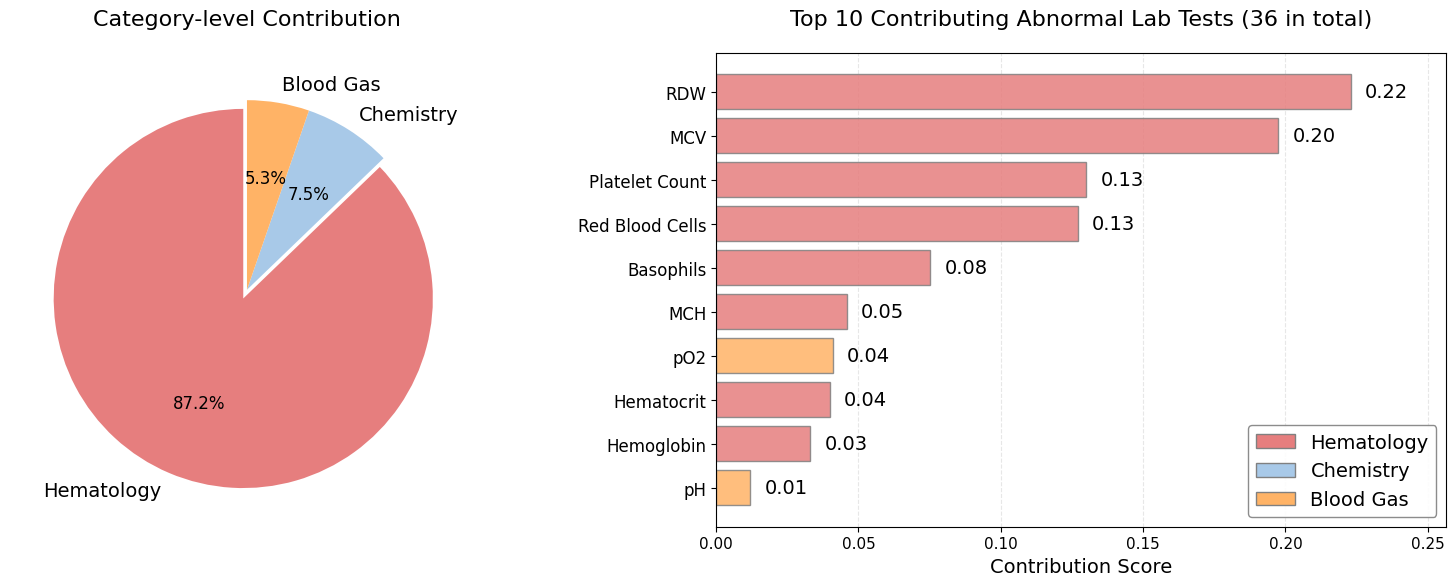

Visualization saved as 'case_lab_interpretation.pdf'


In [17]:
# Patient 843 - Complications of transplanted kidney (996.81) Visualization

category_contrib = {
    'Hematology': 0.8720,
    'Chemistry': 0.0750,
    'Blood Gas': 0.0530
}

top_labs = [
    ('hematology', 'RDW', 0.2230),
    ('hematology', 'MCV', 0.1974),
    ('hematology', 'Platelet Count', 0.1301),
    ('hematology', 'Red Blood Cells', 0.1271),
    ('hematology', 'Basophils', 0.0753),
    ('hematology', 'MCH', 0.0459),
    ('blood gas', 'pO2', 0.0410),
    ('hematology', 'Hematocrit', 0.0400),
    ('hematology', 'Hemoglobin', 0.0331),
    ('blood gas', 'pH', 0.0120)
]

category_colors = {
    'hematology': '#e67e7e', 
    'chemistry': '#a8c9e8',
    'blood gas': '#ffb366' 
}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


categories = list(category_contrib.keys())
contributions = list(category_contrib.values())
colors_pie = ['#e67e7e', '#a8c9e8', '#ffb366']

wedges, texts, autotexts = ax1.pie(
    contributions, 
    labels=categories, 
    colors=colors_pie,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 14},  # , 'weight': 'bold'
    explode=(0.05, 0, 0) 
)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    # autotext.set_weight('bold')

ax1.set_title('Category-level Contribution', 
              fontsize=16, pad=20)

lab_names = [f"{lab[1]}" for lab in top_labs]
lab_contribs = [lab[2] for lab in top_labs]
lab_categories = [lab[0] for lab in top_labs]

bar_colors = [category_colors[cat] for cat in lab_categories]

y_pos = np.arange(len(lab_names))
bars = ax2.barh(y_pos, lab_contribs, color=bar_colors, alpha=0.85, edgecolor='gray', linewidth=1.0)

for i, (bar, contrib) in enumerate(zip(bars, lab_contribs)):
    ax2.text(contrib + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{contrib:.2f}', 
             va='center', ha='left', fontsize=14)

ax2.set_yticks(y_pos)
ax2.set_yticklabels(lab_names, fontsize=12)
ax2.invert_yaxis() 

ax2.set_xlabel('Contribution Score', fontsize=14)
ax2.set_xlim(0, max(lab_contribs) * 1.15)

ax2.set_title('Top 10 Contributing Abnormal Lab Tests (36 in total)', 
              fontsize=16, pad=20)

ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=category_colors['hematology'], edgecolor='gray', label='Hematology'),
    Patch(facecolor=category_colors['chemistry'], edgecolor='gray', label='Chemistry'),
    Patch(facecolor=category_colors['blood gas'], edgecolor='gray', label='Blood Gas')
]
ax2.legend(handles=legend_elements, loc='lower right', fontsize=14, frameon=True, 
           framealpha=0.9, edgecolor='gray')

plt.tight_layout()
plt.savefig('case_lab_interpretation.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'case_lab_interpretation.pdf'")